In [1]:
from uniprobe_data import *
from sqlalchemy import func
from sqlalchemy import distinct

In [2]:
import numpy as np
import networkx as nx

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggstyle')

In [4]:
def fasta_iter(fastafile):
    """
    Iterator of the records present in a .fasta file. Each record is yielded as
    a tuple containg the title line (without '>') and the sequence itself.
    """
    on_open_record = False
    with open(fastafile, 'r') as fasta:
        for line in fasta:
            line = line.strip()
            if len(line) == 0:
                continue
            elif line[0] == '#':
                continue
            elif line[0] == '>':
                # close old record
                if on_open_record:
                    yield title, sequence.upper()
                # new record
                title = line[1:].rstrip()
                sequence = ''
                on_open_record = True
            else:
                sequence += line.rstrip()
    if on_open_record:
        yield title, sequence.upper()

In [5]:
g = nx.read_gpickle('graphs/uniprot.escore0.35.pickle.bz2')
print(len(g))

seq_deg = {node: len(g.node[node]['gene_id']) for node in g}

27211


In [13]:
deg_ordered = [k for (k, v) in sorted(seq_deg.items(), key=lambda v: v[1], reverse=True)]

In [7]:
import numpy as np

def similarity(g, h):
    """
    Returns three similarity measures (the Jaccard index [1], the cosine similarity [2] 
    and the min similarity [3]) for two sets g and h.
    
    [1] P. Jaccard, Bulletin de la Société Vaudoise des Sciences Naturelles 37, 547 (1901).
    [2] Salton, Automatic Text Processing: The Transformation, Analysis, and Retrieval of 
        Information by Computer (Addison-Wesley, Reading, MA, 1989).
    [3] E. Ravasz, A. L. Somera, D. A. Mongru, Z. N. Oltvai, and 
        A.-L. Barabási, Science 297, 1553 (2002).
    """

    n = 1.0 * len(g & h)
    u = 1.0 * len(g | h)
    lg, lh = len(g), len(h)
#     return (1.0 if (lg == 0 and lh == 0) else (n / u if u != 0.0 else np.nan),
#             n / np.sqrt(lg * lh) if (lg != 0 and lh != 0) else np.nan,
#             n / np.min([lg, lh]) if np.min([lg, lh]) != 0 else np.nan)
    return 0.0 if (lg == 0 and lh == 0) else (n / u if u != 0.0 else np.nan)

In [8]:
import networkx as nx

def net_similarity(g, h):
    """
    """
    return similarity(set(g.nodes()), set(h.nodes()))

In [9]:
uniprot_idx = {rec[0].split('|')[1]: i for i, rec in enumerate(fasta_iter('uniprot_seq.fasta'))}
idx_uniprot = {i: rec[0].split('|')[1] for i, rec in enumerate(fasta_iter('uniprot_seq.fasta'))}
l = len(uniprot_idx)

## Ordered removal

In [14]:
bind_set = dict()
for gene_data in session.query(GeneData):
    bind_set[gene_data.uniprot] =\
        set(nx.read_gpickle('graphs/' + str(gene_data.gene_info.genes[0].gene_id) + '.escore0.35.pickle.bz2').nodes())

In [15]:
idxs = [set(deg_ordered[(i - 1) * 1000:i * 1000 - 1]) for i in range(1, 27)]

In [16]:
total_inc = list()

for i in range(len(idxs)):
    
    jaccard = np.zeros(l * l).reshape(l, l)
    for gd1 in session.query(GeneData):
        for gd2 in session.query(GeneData):
            x = similarity(bind_set[gd1.uniprot], bind_set[gd2.uniprot])
            jaccard[uniprot_idx[gd1.uniprot], uniprot_idx[gd2.uniprot]] = 1.0 - x

    total_inc.append(jaccard.sum())

    for uniprot in bind_set:
        bind_set[uniprot] -= idxs[i]

## Shuffled removal

In [17]:
bind_set = dict()
for gene_data in session.query(GeneData):
    bind_set[gene_data.uniprot] =\
        set(nx.read_gpickle('graphs/' + str(gene_data.gene_info.genes[0].gene_id) + '.escore0.35.pickle.bz2').nodes())

In [18]:
import random

deg_shuffled = deg_ordered[:]
random.shuffle(deg_shuffled)
idxs = [set(deg_shuffled[(i - 1) * 1000:i * 1000 - 1]) for i in range(1, 27)]

In [19]:
total_shuffled = list()

for i in range(len(idxs)):
    
    jaccard = np.zeros(l * l).reshape(l, l)
    for gd1 in session.query(GeneData):
        for gd2 in session.query(GeneData):
            x = similarity(bind_set[gd1.uniprot], bind_set[gd2.uniprot])
            jaccard[uniprot_idx[gd1.uniprot], uniprot_idx[gd2.uniprot]] = 1.0 - x

    total_shuffled.append(jaccard.sum())

    for uniprot in bind_set:
        bind_set[uniprot] -= idxs[i]

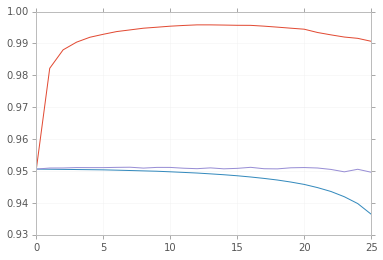

In [22]:
plt.plot(np.array(total_inc) / (l*l))
plt.plot(np.array(total_dec) / (l*l))
plt.plot(np.array(total_shuffled) / (l*l))